In [261]:
import pandas as pd

# Path: data_analysis.py
model_name = 'tgredial'
dataset_name = 'TGReDial'
# data_path = 'bias_analysis_data_set/bias_eval_once_aug/{}/{}/bias_analytic_data.csv'.format(model_name,dataset_name)
data_path = 'bias_analysis_data_set/PopNudge/{}/{}/bias_analytic_data_k50.csv'.format(model_name,dataset_name)
# data_path = 'bias_analysis_data_set/Basic/bias_analysis_data_01/{}/{}/bias_analytic_data.csv'.format(model_name,dataset_name)
data = pd.read_csv(data_path)

### Recommendation Performance Eval

In [262]:
import functools
from abc import ABC, abstractmethod
import torch
import math
from typing import Any, Union, List, Optional, Dict
import json
TScalar = Union[int, float, torch.Tensor]
TVector = Union[List[TScalar], torch.Tensor]

@functools.total_ordering
class Metric(ABC):
    """
    Base class for storing metrics.

    Subclasses should define .value(). Examples are provided for each subclass.
    """

    @abstractmethod
    def value(self) -> float:
        """
        Return the value of the metric as a float.
        """
        pass

    @abstractmethod
    def __add__(self, other: Any) -> 'Metric':
        raise NotImplementedError

    def __iadd__(self, other):
        return self.__radd__(other)

    def __radd__(self, other: Any):
        if other is None:
            return self
        return self.__add__(other)

    def __str__(self) -> str:
        return f'{self.value():.4g}'

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}({self.value():.4g})'

    def __float__(self) -> float:
        return float(self.value())

    def __int__(self) -> int:
        return int(self.value())

    def __eq__(self, other: Any) -> bool:
        if isinstance(other, Metric):
            return self.value() == other.value()
        else:
            return self.value() == other

    def __lt__(self, other: Any) -> bool:
        if isinstance(other, Metric):
            return self.value() < other.value()
        else:
            return self.value() < other

    def __sub__(self, other: Any) -> float:
        """
        Used heavily for assertAlmostEqual.
        """
        if not isinstance(other, float):
            raise TypeError('Metrics.__sub__ is intentionally limited to floats.')
        return self.value() - other

    def __rsub__(self, other: Any) -> float:
        """
        Used heavily for assertAlmostEqual.

        NOTE: This is not necessary in python 3.7+.
        """
        if not isinstance(other, float):
            raise TypeError('Metrics.__rsub__ is intentionally limited to floats.')
        return other - self.value()

    @classmethod
    def as_number(cls, obj: TScalar) -> Union[int, float]:
        if isinstance(obj, torch.Tensor):
            obj_as_number: Union[int, float] = obj.item()
        else:
            obj_as_number = obj  # type: ignore
        assert isinstance(obj_as_number, int) or isinstance(obj_as_number, float)
        return obj_as_number

    @classmethod
    def as_float(cls, obj: TScalar) -> float:
        return float(cls.as_number(obj))

    @classmethod
    def as_int(cls, obj: TScalar) -> int:
        return int(cls.as_number(obj))

    @classmethod
    def many(cls, *objs: List[TVector]) -> List['Metric']:
        """
        Construct many of a Metric from the base parts.

        Useful if you separately compute numerators and denomenators, etc.
        """
        lengths = [len(o) for o in objs]
        if len(set(lengths)) != 1:
            raise IndexError(f'Uneven {cls.__name__} constructions: {lengths}')
        return [cls(*items) for items in zip(*objs)]


class AverageMetric(Metric):
    """
    Class that keeps a running average of some metric.

    Examples of AverageMetrics include hits@1, F1, accuracy, etc. These metrics all have
    per-example values that can be directly mapped back to a teacher.
    """

    __slots__ = ('_numer', '_denom')

    def __init__(self, numer: TScalar, denom: TScalar = 1.0):
        self._numer = self.as_number(numer)
        self._denom = self.as_number(denom)

    def __add__(self, other: Optional['AverageMetric']) -> 'AverageMetric':
        # NOTE: hinting can be cleaned up with "from __future__ import annotations" when
        # we drop Python 3.6
        if other is None:
            return self
        full_numer: TScalar = self._numer + other._numer
        full_denom: TScalar = self._denom + other._denom
        # always keep the same return type
        return type(self)(numer=full_numer, denom=full_denom)

    def value(self) -> float:
        if self._numer == 0 and self._denom == 0:
            # don't nan out if we haven't counted anything
            return 0.0
        if self._denom == 0:
            return float('nan')
        return self._numer / (1.0 * self._denom)


class Metrics(object):
    """
    Metrics aggregator.
    """

    def __init__(self):
        self._data = {}

    def __str__(self):
        return str(self._data)

    def __repr__(self):
        return f'Metrics({repr(self._data)})'

    def get(self, key: str):
        if key in self._data.keys():
            return self._data[key].value()
        else:
            raise

    def __getitem__(self, item):
        return self.get(item)

    def add(self, key: str, value: Optional[Metric]) -> None:
        """
        Record an accumulation to a metric.
        """
        self._data[key] = self._data.get(key) + value

    def report(self):
        """
        Report the metrics over all data seen so far.
        """
        return {k: v for k, v in self._data.items()}

    def clear(self):
        """
        Clear all the metrics.
        """
        self._data.clear()


class HitMetric(AverageMetric):
    @staticmethod
    def compute(ranks, label, k) -> 'HitMetric':
        return HitMetric(int(label in ranks[:k]))


class NDCGMetric(AverageMetric):
    @staticmethod
    def compute(ranks, label, k) -> 'NDCGMetric':
        if label in ranks[:k]:
            label_rank = ranks.index(label)
            return NDCGMetric(1.0 / math.log2(label_rank + 2))
        return NDCGMetric(0)


class MRRMetric(AverageMetric):
    @staticmethod
    def compute(ranks, label, k) -> 'MRRMetric':
        if label in ranks[:k]:
            label_rank = ranks.index(label)
            return MRRMetric(1.0 / (label_rank + 1))
        return MRRMetric(0)
rec_metrics = Metrics()

def rec_evaluate(ranks, label):
    for k in [1, 10, 50]:
        if len(ranks) >= k:
            rec_metrics.add(f"hit@{k}", HitMetric.compute(ranks, label, k))
            rec_metrics.add(f"ndcg@{k}", NDCGMetric.compute(ranks, label, k))
            rec_metrics.add(f"mrr@{k}", MRRMetric.compute(ranks, label, k))

movie_ids = json.load(open('Movie_IDS/TGReDial/PKUSEG/movie_ids.json', 'r'))

for idx, row in data.iterrows():
    rec_rank = row['Prediction']
    item_index = row['target_item_index']
    item_id = str(movie_ids.index(item_index))
    rec_evaluate(rec_rank, item_id)

In [263]:
rec_metrics.report()

{'hit@1': HitMetric(0),
 'ndcg@1': NDCGMetric(0),
 'mrr@1': MRRMetric(0),
 'hit@10': HitMetric(0.01025),
 'ndcg@10': NDCGMetric(0.005944),
 'mrr@10': MRRMetric(0.004501),
 'hit@50': HitMetric(0.02674),
 'ndcg@50': NDCGMetric(0.009639),
 'mrr@50': MRRMetric(0.005339)}

### Popularity Bias Eval

In [5]:
import json
tok_type = 'PKUSEG'
movie_id_dir = f'Movie_IDs/tgredial/{tok_type}/movie_ids.json'
movie_entity_ids = json.load(open(movie_id_dir, 'r', encoding='utf-8'))

def convert_ids(x):    
    return movie_entity_ids.index(x)

# target_item for tgredial and target_item_index for the rest
# data['item'] = list(map(convert_ids, data['target_item']))
# data['item'] = list(map(convert_ids, data['target_item_index']))

In [6]:
entity2id_file = 'training_data/tgredial/entity2id.json'
entity2id = json.load(open(entity2id_file, 'r', encoding='utf-8'))
movie_ids = json.load(open('Movie_IDs/TGReDial/PKUSEG/movie_ids.json', 'r'))
training_data = json.load(open('training_data/tgredial/train_data.json', 'r', encoding='utf-8'))

print(movie_ids[:10])
print(type(movie_ids[0]))
item_frequency = {}
for value in entity2id.values():
    # if key[:2] == '<h':
    if int(value) in movie_ids:
        item_frequency[int(value)] = 1

# for utt in training_data:
#     dialogs = utt['dialog']
#     for dialog in dialogs:
#         if len(dialog['movies']) == 0:
#             continue
#         mentioned_movies = [int(entity2id[movie]) for movie in dialog['movies'] if movie in entity2id]
#         for movie in mentioned_movies:
#             if movie in item_frequency:
#                 item_frequency[movie] += 1

for utt in training_data:
    dialogs = utt['messages']
    for dialog in dialogs:
        if len(dialog['movie']) == 0:
            continue
        mentioned_movies = [int(entity2id[movie]) for movie in dialog['movie'] if movie in entity2id]
        for movie in mentioned_movies:
            if movie in item_frequency:
                item_frequency[movie] += 1

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
<class 'int'>


In [7]:
item_frequency = {k: v for k, v in sorted(item_frequency.items(), key=lambda item: item[1], reverse=True)}
print(list(item_frequency.keys())[-10:])
print(list(item_frequency.values())[-10:])
len(item_frequency)

[33520, 33521, 33522, 33524, 33526, 33527, 33528, 33529, 33530, 33531]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


31985

In [13]:
json.dump(item_frequency, open('Movie_IDs/TGReDial/PKUSEG/movie_frequency_tgredial.json', 'w', encoding='utf-8'))

In [15]:
interacted_items = 0
for item in item_frequency:
    if item_frequency[item] != 0:
        interacted_items += 1
print(interacted_items / len(item_frequency) * 1.0)   

0.3482257308113178


In [8]:
interacted_items = 0
for item in item_frequency:
    if item_frequency[item] >= 5:
        interacted_items += 1
print(interacted_items / len(item_frequency) * 1.0)   

0.061685164921056745


In [5]:
len(item_frequency)

60741

Text(0, 0.5, 'Frequency')

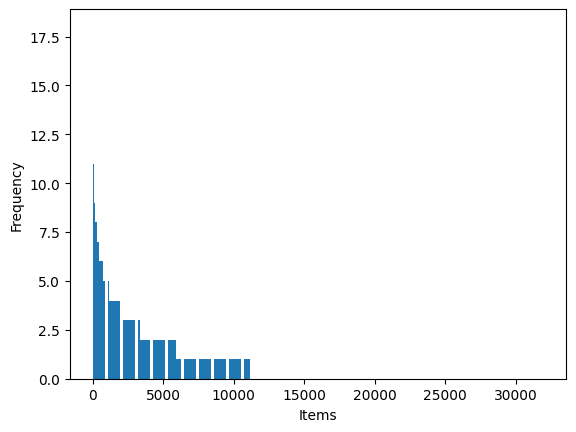

In [14]:
# TGReDial Dataset
import matplotlib.pyplot as plt
item_frequency = {k: v for k, v in sorted(item_frequency.items(), key=lambda item: item[1], reverse=True)}
plt.bar(range(len(item_frequency)), list(item_frequency.values()), align='center')
plt.xlabel('Items')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

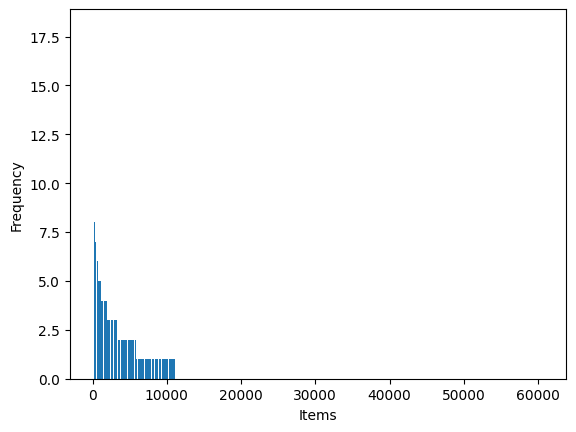

In [7]:
# TGReDial Dataset
import matplotlib.pyplot as plt
item_frequency = {k: v for k, v in sorted(item_frequency.items(), key=lambda item: item[1], reverse=True)}
plt.bar(range(len(item_frequency)), list(item_frequency.values()), align='center')
plt.xlabel('Items')
plt.ylabel('Frequency')

In [90]:
pop_items = list(item_frequency.keys())[:int(len(item_frequency) * 0.1)]
len(pop_items)

3198

In [11]:
pop_score_dict = {}
for index,value in enumerate(list(item_frequency.keys())):
  pop_score_dict[value] = 1 - index / len(item_frequency)

## Calculate popularity score of recommendations

In [264]:
import numpy as np
def rank_utility(items):
    utility_score = 0
    for idx in range(1, len(items) + 1):
        if items[idx - 1] in pop_items:
            utility_score += 1 / (np.log(idx) + 1) 
    return utility_score

def pop_coverage(items):
    return len(set(items).intersection(set(pop_items))) / (1.0 * len(items))

def list_to_int(item_str):
    item_ids = item_str.strip('][').split(', ')
    while("" in item_ids):
        item_ids.remove("")
    return list(map(int, item_ids))

data['Prediction_items'] = list(map(list_to_int, data['Prediction']))
data['pop_coverage'] = list(map(pop_coverage, data['Prediction_items']))
data['rank_utility'] = list(map(rank_utility, data['Prediction_items']))
data['pop_bias'] = data['pop_coverage'] * data['rank_utility']
data['pop_bias'].mean()

0.8259874961598936

In [265]:
data['pop_bias'].std()

0.4630539347244167

In [266]:
# Calculate CEP score
from scipy.stats.stats import pearsonr

def compute_pop_scores(pop_score_dict, items):
    for item in items:
        if item not in pop_score_dict:
            pop_score_dict[item] = 0.5
    return [pop_score_dict[item] for item in items]

pop_scores = [compute_pop_scores(pop_score_dict, row['Prediction_items']) for _, row in data.iterrows()]
data['pop_scores'] = pop_scores

new_conv = True
cep_scores = []
for idx, row in data.iterrows():
    if new_conv:
        new_conv = False
        cep_scores.append(0.5)
    else:
        if row['conv_id'] != data.at[idx-1, 'conv_id']:
            new_conv=True
            cep_scores.append(0.5)
            continue
        pearsonr_score = pearsonr(row['pop_scores'], data.at[idx-1, 'pop_scores'])[0]
        if np.isnan(pearsonr_score):
            cep_scores.append(0.5)
            print(row['pop_scores'], data.at[idx-1, 'pop_scores'])
        else:
            cep_scores.append(np.abs(pearsonr_score))
        # pearsonr_score = 0.5 if np.isnan(pearsonr_score) else pearsonr_score
        # pearsonr_score = np.abs(pearsonr_score)
        # cep_scores.append(pearsonr_score)
data['cep_score'] = cep_scores
data['cep_pop_score'] = data['cep_score'] * data['pop_bias']
print("mean: ", data['cep_pop_score'].mean())
print("std: ", data['cep_pop_score'].std())

/var/folders/00/7dpx5xyd31x3l547cfrv98rc0000gn/T/ipykernel_1844/817341090.py:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


mean:  0.3076813882826956
std:  0.248426487984089


In [267]:
# calculate UIOP score
data['target_pop_score'] = data['target_item_index'].map(pop_score_dict)
data['UIOP'] = np.abs(data['pop_bias'] - data['target_pop_score']) 
print("mean: ", data['UIOP'].mean())
print("std: ", data['UIOP'].std())

mean:  0.3719693925177613
std:  0.2996743638529572


In [108]:
# set nan to 0.5 in data
if data['UIOP'].isnull().values.any():
    data['UIOP'] = data['UIOP'].fillna(0.5)

### Redial Dataset

In [15]:
redial_tgredial = list(data['pop_bias'])

In [24]:
tgredial_tgredial = list(data['pop_bias'])

In [29]:
kbrd_tgredial = list(data['pop_bias'])

In [35]:
kgsf_tgredial = list(data['pop_bias'])

In [42]:
uccr_tgredial = list(data['pop_bias'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fab060981c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fab060983a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fab03962d40>],
 'medians': [<matplotlib.lines.Line2D at 0x7fab06098c40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fab06098ee0>],
 'means': []}

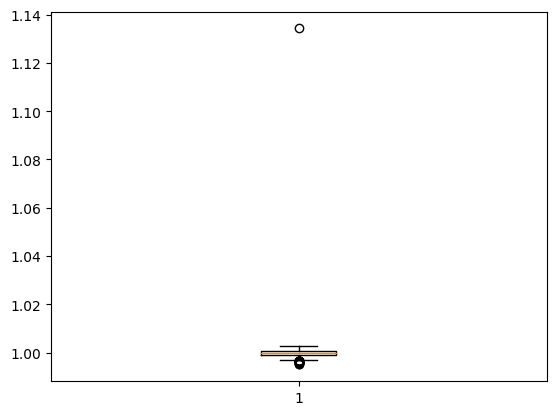

In [16]:
# redial_redial
# Average scores: 0.9999805670861777
plt.boxplot(redial_tgredial)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fab060b7010>,
 'caps': [<matplotlib.lines.Line2D at 0x7fab1adb2470>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fab05f1a9b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fab1adb29b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fab1adb2c50>],
 'means': []}

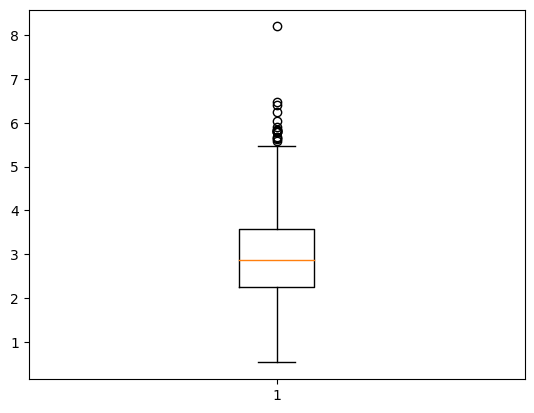

In [25]:
# tgredial_redial
# Average scores: 2.958525555190106
plt.boxplot(tgredial_tgredial)

{'whiskers': [<matplotlib.lines.Line2D at 0x7faa96a4a800>,
 'caps': [<matplotlib.lines.Line2D at 0x7faa96a4ad40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faa96a4a560>],
 'medians': [<matplotlib.lines.Line2D at 0x7faa96a4b250>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faa96a4b4f0>],
 'means': []}

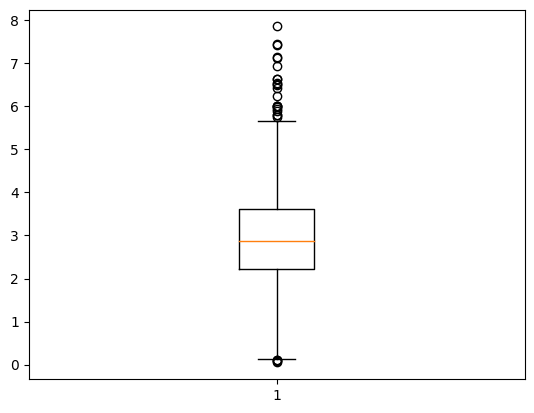

In [31]:
# kbrd_redial
# Average scores: 2.9404640663607267
plt.boxplot(kbrd_tgredial)

{'whiskers': [<matplotlib.lines.Line2D at 0x7faaeb90b580>,
 'caps': [<matplotlib.lines.Line2D at 0x7faaeb90bac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faaeb90b2e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7faaeb924040>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faaeb9242e0>],
 'means': []}

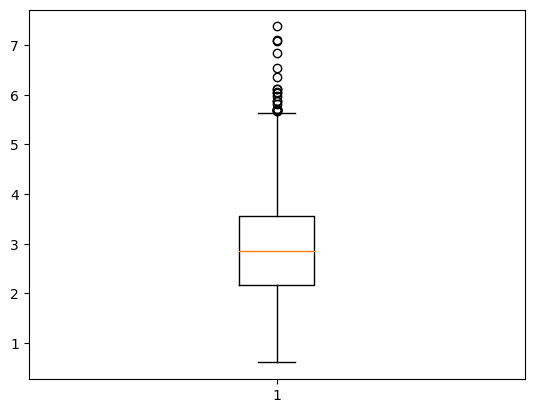

In [36]:
# kgsf_redial
# Average scores: 2.9159886874461507
plt.boxplot(kgsf_tgredial)

{'whiskers': [<matplotlib.lines.Line2D at 0x7faaebe83250>,
 'caps': [<matplotlib.lines.Line2D at 0x7faaebe83790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faaebe82fb0>],
 'medians': [<matplotlib.lines.Line2D at 0x7faaebe83cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faaebe83f70>],
 'means': []}

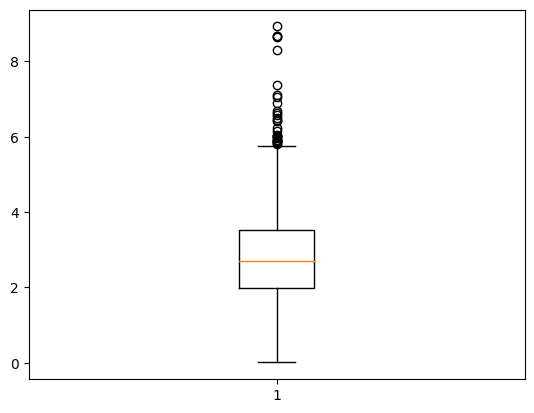

In [43]:
# kgsf_redial
# Average scores: 2.7914066965275044
plt.boxplot(uccr_tgredial)

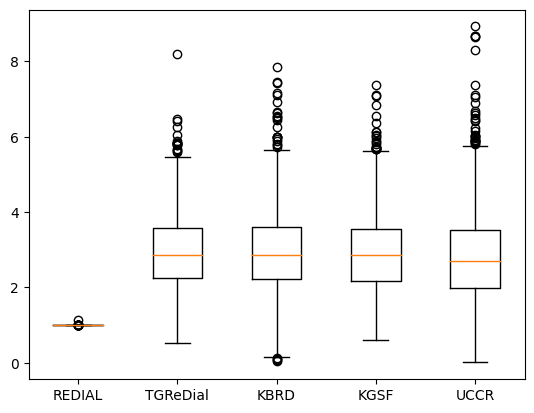

In [45]:
%matplotlib inline
plt.boxplot([redial_redial, tgredial_tgredial, kbrd_tgredial, kgsf_tgredial, uccr_tgredial], labels=['REDIAL', 'TGReDial', 'KBRD', 'KGSF', 'UCCR'])
plt.savefig('pop_bias_tgredial.pdf')

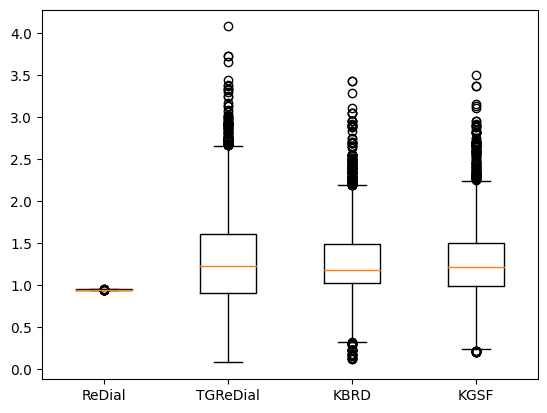

In [213]:
%matplotlib inline
plt.boxplot([redial_redial, tgredial_redial, kbrd_redial, kgsf_redial], labels=['ReDial', 'TGReDial', 'KBRD', 'KGSF'])
plt.savefig('pop_bias_0.1.pdf')

0.6105814275040766


{'whiskers': [<matplotlib.lines.Line2D at 0x7faa97a39cf0>,
 'caps': [<matplotlib.lines.Line2D at 0x7faa97a3a230>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faa97a39a50>],
 'medians': [<matplotlib.lines.Line2D at 0x7faa97a3a770>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faa97a3aa10>],
 'means': []}

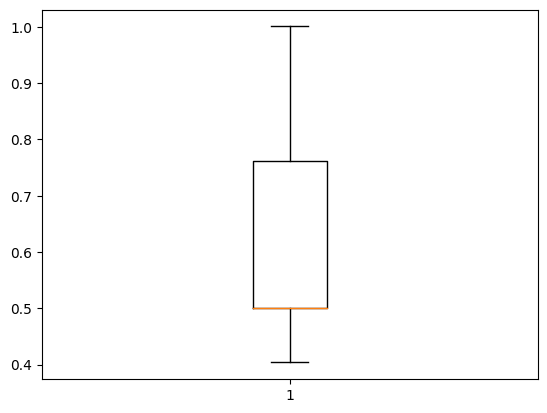

In [75]:
# redial_tgredial_cep_pop
redial_tgredial_cep_pop = list(data['cep_pop_score'])
print(np.average(redial_tgredial_cep_pop))
plt.boxplot(redial_tgredial_cep_pop)

1.100928475109374


{'whiskers': [<matplotlib.lines.Line2D at 0x7fab19608820>,
 'caps': [<matplotlib.lines.Line2D at 0x7faa9a3000a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fab19608f70>],
 'medians': [<matplotlib.lines.Line2D at 0x7faa9a3005e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faa9a300880>],
 'means': []}

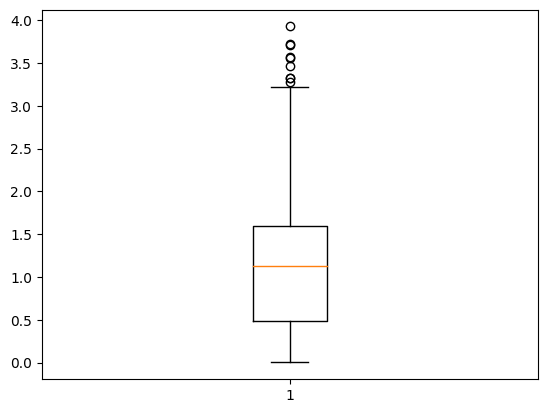

In [60]:
# kbrd_tgredial_cep_pop
kbrd_tgredial_cep_pop = list(data['cep_pop_score'])
print(np.average(kbrd_tgredial_cep_pop))
plt.boxplot(kbrd_tgredial_cep_pop)

1.0840688137780512


{'whiskers': [<matplotlib.lines.Line2D at 0x7fab04393250>,
 'caps': [<matplotlib.lines.Line2D at 0x7fab04393070>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fab04391240>],
 'medians': [<matplotlib.lines.Line2D at 0x7fab04393820>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fab043938e0>],
 'means': []}

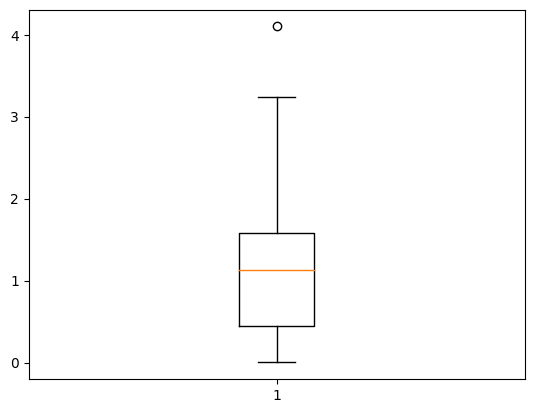

In [69]:
# tgredial_tgredial_cep_pop
tgredial_tgredial_cep_pop = list(data['cep_pop_score'])
print(np.average(tgredial_tgredial_cep_pop))
plt.boxplot(tgredial_tgredial_cep_pop)

1.1719516204641756


{'whiskers': [<matplotlib.lines.Line2D at 0x7faa96de5240>,
 'caps': [<matplotlib.lines.Line2D at 0x7faa96de5780>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faa96de4fa0>],
 'medians': [<matplotlib.lines.Line2D at 0x7faa96de5cc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faa96de5f60>],
 'means': []}

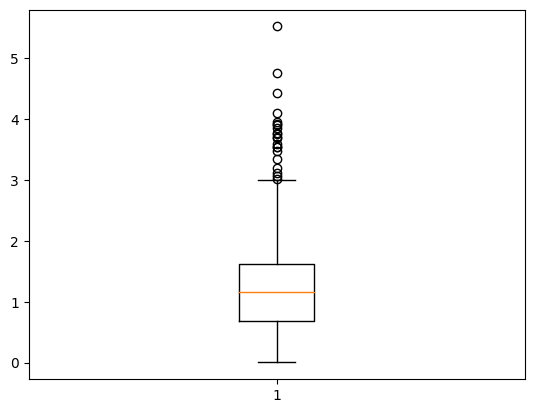

In [54]:
# kgsf_tgredial_cep_pop
kgsf_tgredial_cep_pop = list(data['cep_pop_score'])
print(np.average(kgsf_tgredial_cep_pop))
plt.boxplot(kgsf_tgredial_cep_pop)

1.0652243732337225


{'whiskers': [<matplotlib.lines.Line2D at 0x7fab043a8f70>,
 'caps': [<matplotlib.lines.Line2D at 0x7fab043aa0e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faa96dd3c10>],
 'medians': [<matplotlib.lines.Line2D at 0x7fab043aa590>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fab043aa830>],
 'means': []}

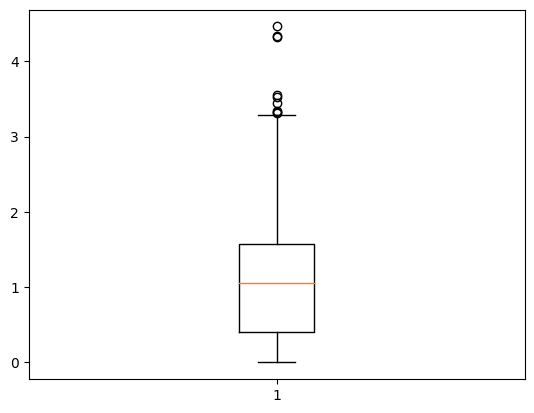

In [48]:
# uccr_tgredial_cep
uccr_tgredial_cep_pop = list(data['cep_pop_score'])
print(np.average(uccr_tgredial_cep_pop))
plt.boxplot(uccr_tgredial_cep_pop)

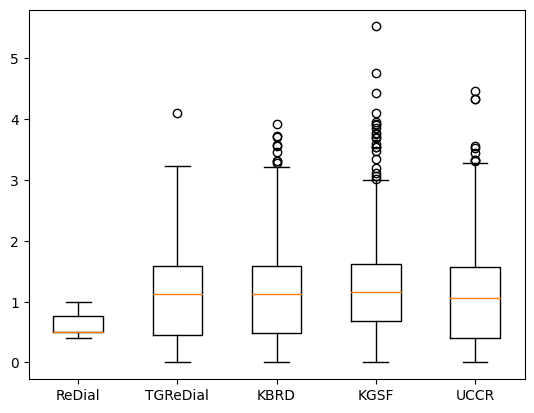

In [77]:
%matplotlib inline
plt.boxplot([redial_tgredial_cep_pop, tgredial_tgredial_cep_pop, kbrd_tgredial_cep_pop, kgsf_tgredial_cep_pop, uccr_tgredial_cep_pop], labels=['ReDial', 'TGReDial', 'KBRD', 'KGSF', 'UCCR'])
plt.savefig('cep_pop_bias_tgredial.pdf')

0.16115097091555655


{'whiskers': [<matplotlib.lines.Line2D at 0x7fab03cd7460>,
 'caps': [<matplotlib.lines.Line2D at 0x7fab03cd79a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fab03cd71c0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fab03cd7ee0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fab0b6b81c0>],
 'means': []}

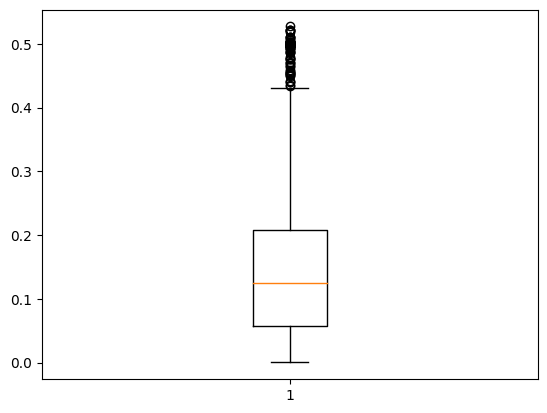

In [82]:
# redial_tgredial_uiop
redial_tgredial_uiop = list(data['UIOP'])
print(np.average(redial_tgredial_uiop))
plt.boxplot(redial_tgredial_uiop)

2.115616157425771


{'whiskers': [<matplotlib.lines.Line2D at 0x7faa9a5e9e70>,
 'caps': [<matplotlib.lines.Line2D at 0x7faa9a5ea3b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faa9a5e9bd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7faa9a5ea8f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faa9a5eab90>],
 'means': []}

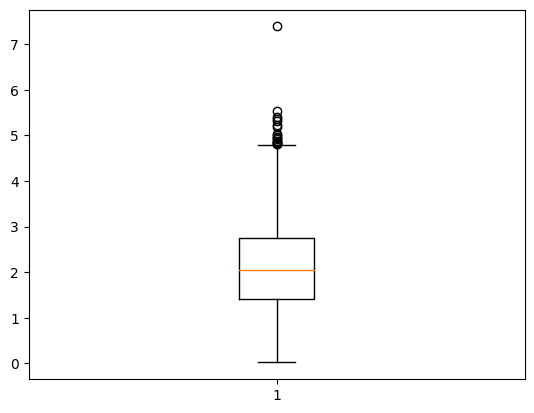

In [88]:
# tgredial_tgredial_uiop
tgredial_tgredial_uiop = list(data['UIOP'])
print(np.average(tgredial_tgredial_uiop))
plt.boxplot(tgredial_tgredial_uiop)

2.1100519383834486


{'whiskers': [<matplotlib.lines.Line2D at 0x7fab03c84340>,
 'caps': [<matplotlib.lines.Line2D at 0x7fab03c86ad0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fab03c848b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fab03c875e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fab03c87880>],
 'means': []}

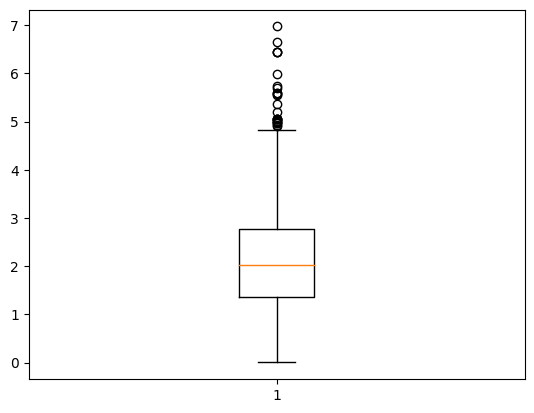

In [95]:
# kbrd_tgredial_uiop
kbrd_tgredial_uiop = list(data['UIOP'])
print(np.average(kbrd_tgredial_uiop))
plt.boxplot(kbrd_tgredial_uiop)

2.0707898433766516


{'whiskers': [<matplotlib.lines.Line2D at 0x7faa97ba1f00>,
 'caps': [<matplotlib.lines.Line2D at 0x7faa97ba2920>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faa97ba0940>],
 'medians': [<matplotlib.lines.Line2D at 0x7faa97ba05e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faa97ba3760>],
 'means': []}

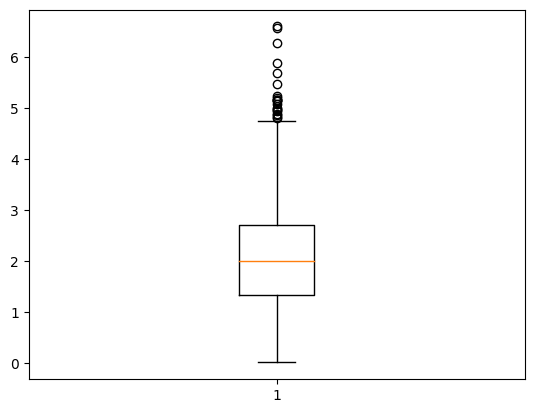

In [102]:
# kgsf_tgredial_uiop
kgsf_tgredial_uiop = list(data['UIOP'])
print(np.average(kgsf_tgredial_uiop))
plt.boxplot(kgsf_tgredial_uiop)

1.9913108096004493


{'whiskers': [<matplotlib.lines.Line2D at 0x7fab184c6a70>,
 'caps': [<matplotlib.lines.Line2D at 0x7fab184c62c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faa9a4ffe80>],
 'medians': [<matplotlib.lines.Line2D at 0x7fab184c4f70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fab184c42b0>],
 'means': []}

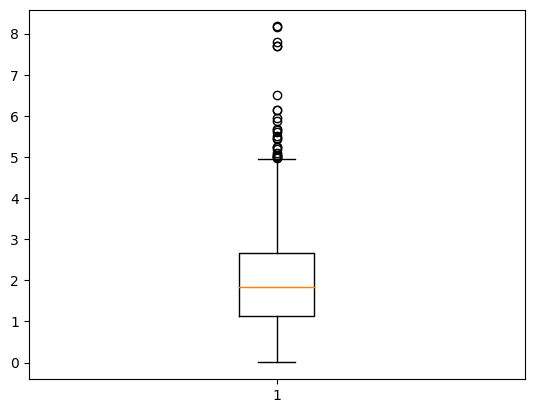

In [109]:
# uccr_tgredial_uiop
uccr_tgredial_uiop = list(data['UIOP'])
print(np.average(uccr_tgredial_uiop))
plt.boxplot(uccr_tgredial_uiop)

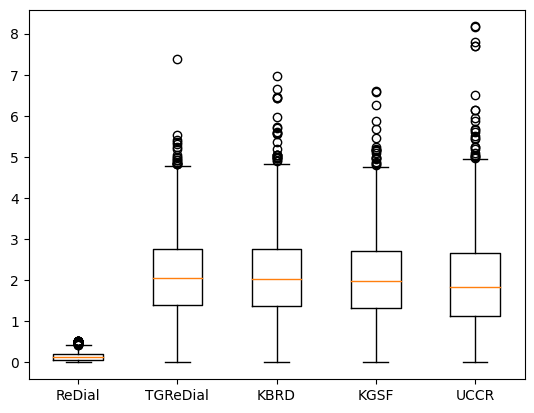

In [110]:
%matplotlib inline
plt.boxplot([redial_tgredial_uiop, tgredial_tgredial_uiop, kbrd_tgredial_uiop, kgsf_tgredial_uiop, uccr_tgredial_uiop], labels=['ReDial', 'TGReDial', 'KBRD', 'KGSF', 'UCCR'])
# plt.boxplot([redial_redial, tgredial_redial, kbrd_redial, kgsf_redial], labels=['ReDial', 'TGReDial', 'KBRD', 'KGSF'])
plt.savefig('uiop_pop_bias_tgredial.pdf')

0.6105774245836842


{'whiskers': [<matplotlib.lines.Line2D at 0x7fab041d8c70>,
 'caps': [<matplotlib.lines.Line2D at 0x7fab041d91b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fab041d89d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fab041d96f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fab041d9990>],
 'means': []}

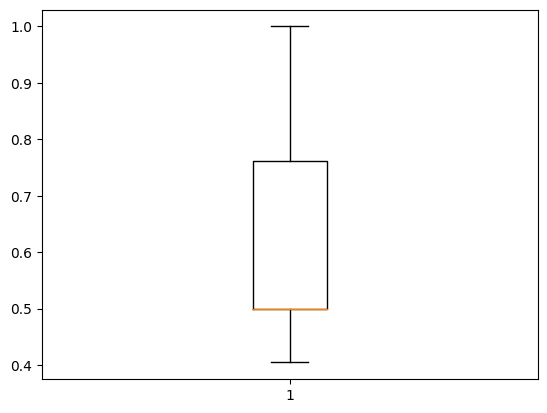

In [129]:
# redial_tgredial
redial_tgredial_cep = list(data['cep_score'])
print(np.average(redial_tgredial_cep))
plt.boxplot(redial_tgredial_cep)

0.3695992785108314


{'whiskers': [<matplotlib.lines.Line2D at 0x7faa9a27f8e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7faa9a27e830>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faa9a27f910>],
 'medians': [<matplotlib.lines.Line2D at 0x7faa97c2ecb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faa9a484a90>],
 'means': []}

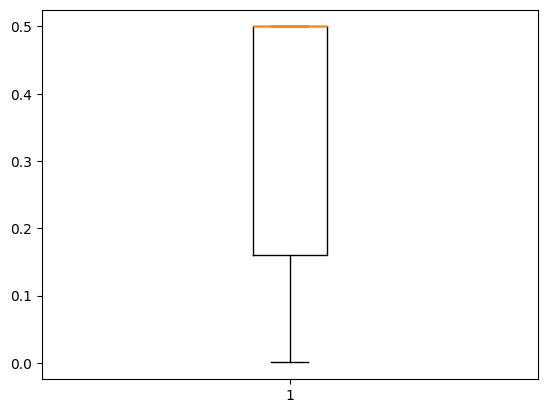

In [116]:
# tgredial_tgredial_cep
tgredial_tgredial_cep = list(data['cep_score'])
print(np.average(tgredial_tgredial_cep))
plt.boxplot(tgredial_tgredial_cep)

0.3757571229680629


{'whiskers': [<matplotlib.lines.Line2D at 0x7faa9a0c4340>,
 'caps': [<matplotlib.lines.Line2D at 0x7faa9a0c4880>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faa9a0c40a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7faa9a0c4dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faa9a0c5060>],
 'means': []}

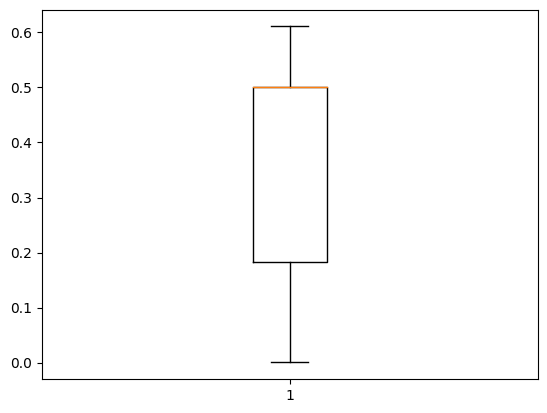

In [134]:
# kbrd_tgredial_cep
kbrd_tgredial_cep = list(data['cep_score'])
print(np.average(kbrd_tgredial_cep))
plt.boxplot(kbrd_tgredial_cep)

0.4078123352624819


{'whiskers': [<matplotlib.lines.Line2D at 0x7faa98b11750>,
 'caps': [<matplotlib.lines.Line2D at 0x7faa98b112a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faa98b12230>],
 'medians': [<matplotlib.lines.Line2D at 0x7faa98b129e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faa98b11300>],
 'means': []}

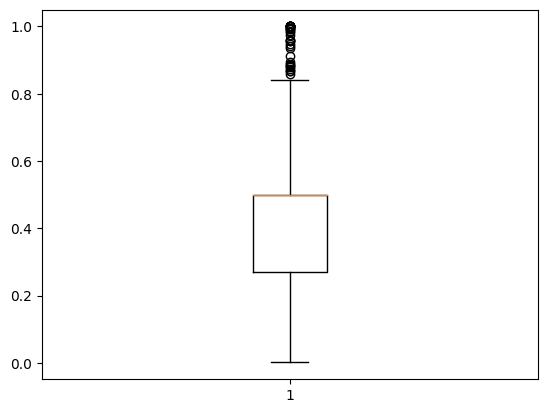

In [139]:
# kgsf_tgredial_cep
kgsf_tgredial_cep = list(data['cep_score'])
print(np.average(kgsf_tgredial_cep))
plt.boxplot(kgsf_tgredial_cep)

0.3773859638324838


{'whiskers': [<matplotlib.lines.Line2D at 0x7faa976c67a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7faa976c6ce0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faa976c6500>],
 'medians': [<matplotlib.lines.Line2D at 0x7faa976c7220>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faa976c74c0>],
 'means': []}

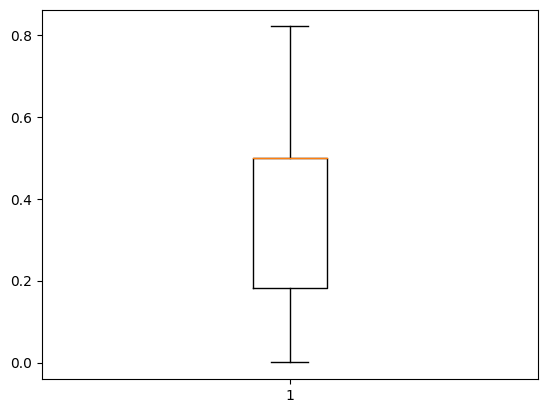

In [111]:
# uccr_tgredial_cep
uccr_tgredial_cep = list(data['cep_score'])
print(np.average(uccr_tgredial_cep))
plt.boxplot(uccr_tgredial_cep)

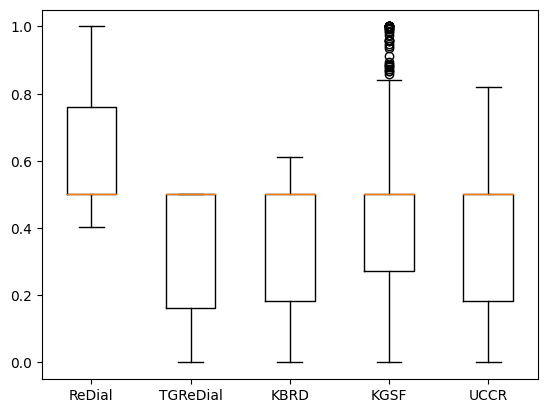

In [140]:
%matplotlib inline
plt.boxplot([redial_tgredial_cep, tgredial_tgredial_cep, kbrd_tgredial_cep, kgsf_tgredial_cep, uccr_tgredial_cep], labels=['ReDial', 'TGReDial', 'KBRD', 'KGSF', 'UCCR'])
plt.savefig('cep_bias_only_tgredial.pdf')

### Cross Trun Repetition Bias

In [106]:
import rbo
ctr_scores = []
new_conv = True
for idx, row in data.iterrows():
    if new_conv:
        new_conv = False
    else:
        if idx+1 < len(data) and row['conv_id'] != data.at[idx+1, 'conv_id']:
            new_conv=True
            continue
        ctr_score = rbo.RankingSimilarity(row['Prediction_items'], data.at[idx-1, 'Prediction_items']).rbo(p=0.1)
        ctr_scores.append(ctr_score)

0.9999384178905175


{'whiskers': [<matplotlib.lines.Line2D at 0x7f92148244c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9214824a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9214824220>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9214824f40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f92148251e0>],
 'means': []}

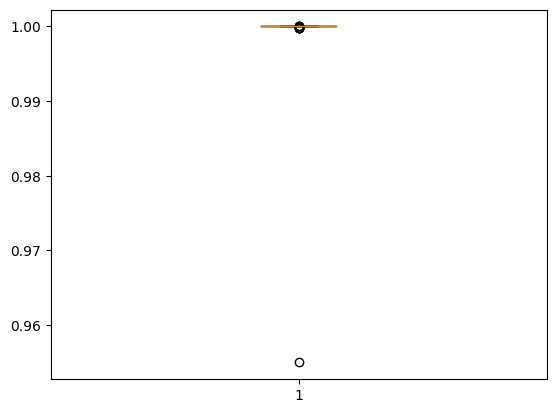

In [107]:
# redial_ctr
import matplotlib.pyplot as plt
redial_ctr_score = ctr_scores
print(np.average(redial_ctr_score))
plt.boxplot(redial_ctr_score)

0.012949211303960546


{'whiskers': [<matplotlib.lines.Line2D at 0x7f9213ab2110>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9213ab2650>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9213ab1270>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9213ab2b90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9213ab2e30>],
 'means': []}

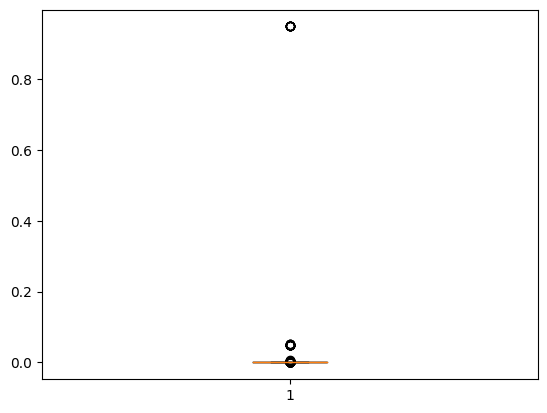

In [102]:
# tgredial_ira
import matplotlib.pyplot as plt
tgredial_ctr_score = ctr_scores
print(np.average(tgredial_ctr_score))
plt.boxplot(tgredial_ctr_score)

0.24734533641767745


{'whiskers': [<matplotlib.lines.Line2D at 0x7f9213b13940>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9213b13e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9213b136a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9213b24400>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9213b246a0>],
 'means': []}

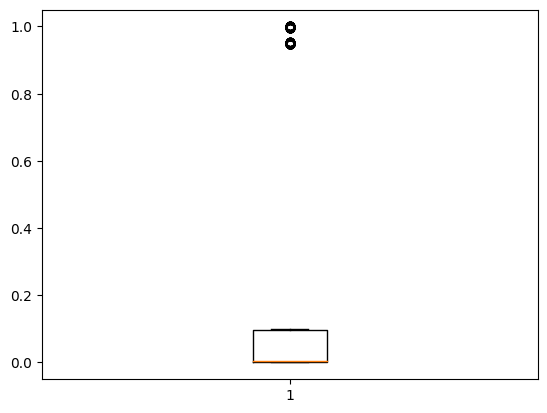

In [97]:
# kbrd_ira
import matplotlib.pyplot as plt
kbrd_ctr_score = ctr_scores
print(np.average(kbrd_ctr_score))
plt.boxplot(kbrd_ctr_score)

0.20653776150862255


{'whiskers': [<matplotlib.lines.Line2D at 0x7f91ff8a3280>,
 'caps': [<matplotlib.lines.Line2D at 0x7f91ff8a37c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f91ff8a2fe0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f91ff8a3d00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f91ff8a3fa0>],
 'means': []}

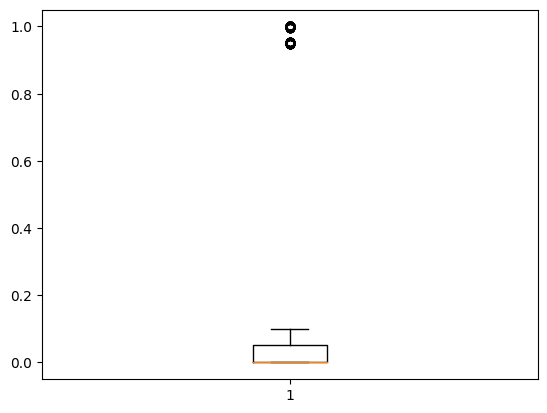

In [90]:
# kgsf_ira
import matplotlib.pyplot as plt
kgsf_ctr_score = ctr_scores
print(np.average(kgsf_ctr_score))
plt.boxplot(kgsf_ctr_score)

0.37416994381810825


{'whiskers': [<matplotlib.lines.Line2D at 0x7f91fcc00610>,
 'caps': [<matplotlib.lines.Line2D at 0x7f91fcc00b50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f91fcc00370>],
 'medians': [<matplotlib.lines.Line2D at 0x7f91fcc01090>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f91fcc01330>],
 'means': []}

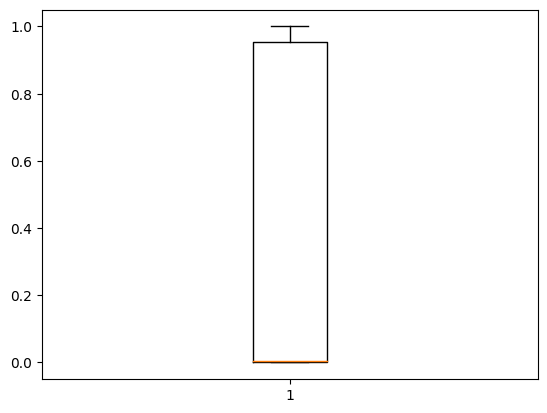

In [85]:
# uccr_ctr
import matplotlib.pyplot as plt
uccr_ctr_score = ctr_scores
print(np.average(uccr_ctr_score))
plt.boxplot(uccr_ctr_score)

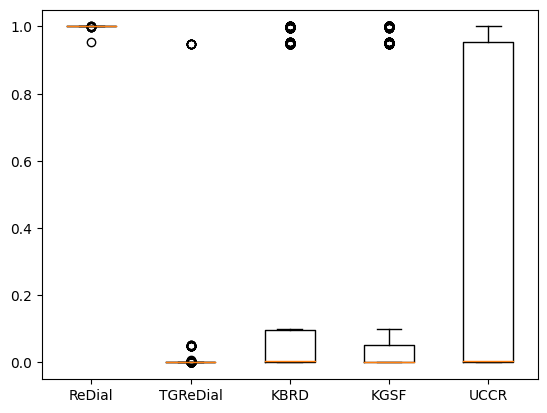

In [108]:
import matplotlib.pyplot as plt
plt.boxplot([redial_ctr_score, tgredial_ctr_score, kbrd_ctr_score, kgsf_ctr_score, uccr_ctr_score], labels=['ReDial', 'TGReDial', 'KBRD', 'KGSF', 'UCCR'])
plt.savefig('ctr_bias_tgredial.pdf')

### Initial Recommendation Adhere Bias

In [81]:
# Calculate the IRA bias score
import rbo
ira_scores = []
new_conv = True
initial_idx = 0
for idx, row in data.iterrows():
    if new_conv:
        new_conv = False
    else:
        if idx+1 < len(data) and row['conv_id'] != data.at[idx+1, 'conv_id']:
            new_conv=True
            initial_idx = idx+1
        ira_score = rbo.RankingSimilarity(row['Prediction_items'], data.at[initial_idx, 'Prediction_items']).rbo(p=0.1)
    ira_scores.append(ira_score)

0.9999383355614935


{'whiskers': [<matplotlib.lines.Line2D at 0x7f920358a6e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f920358ac20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f920358a440>],
 'medians': [<matplotlib.lines.Line2D at 0x7f920358b160>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f920358b400>],
 'means': []}

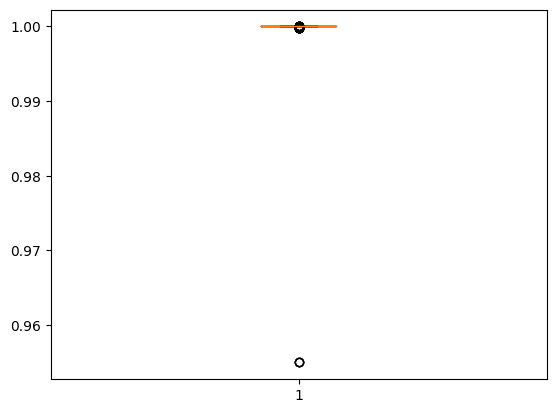

In [62]:
# redial_ira
import matplotlib.pyplot as plt
redial_ira_score = ira_scores
print(np.average(redial_ira_score))
plt.boxplot(redial_ira_score)

0.0048538064867019864


{'whiskers': [<matplotlib.lines.Line2D at 0x7f92030f4ac0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f92030f5000>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f92030f4820>],
 'medians': [<matplotlib.lines.Line2D at 0x7f92030f5540>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f92030f57e0>],
 'means': []}

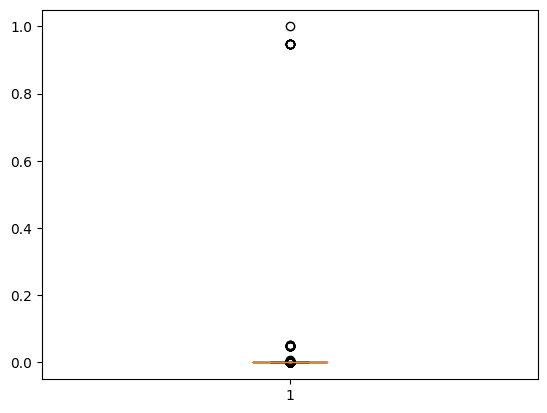

In [67]:
# tgredial_ira
import matplotlib.pyplot as plt
tgredial_ira_score = ira_scores
print(np.average(tgredial_ira_score))
plt.boxplot(tgredial_ira_score)

0.08260746496247691


{'whiskers': [<matplotlib.lines.Line2D at 0x7f92035a7640>,
 'caps': [<matplotlib.lines.Line2D at 0x7f92035a7b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f92035a73a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9213868100>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f92138683a0>],
 'means': []}

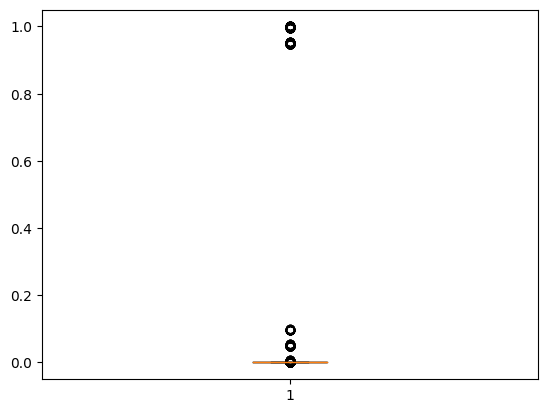

In [72]:
# kbrd_ira
import matplotlib.pyplot as plt
kbrd_ira_score = ira_scores
print(np.average(kbrd_ira_score))
plt.boxplot(kbrd_ira_score)

0.08260746496247691


{'whiskers': [<matplotlib.lines.Line2D at 0x7f920364e470>,
 'caps': [<matplotlib.lines.Line2D at 0x7f920364e9b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f920364e1d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f920364eef0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f920364f190>],
 'means': []}

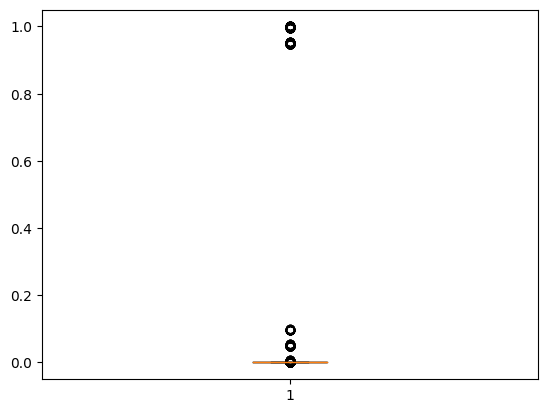

In [76]:
# kgsf_ira
import matplotlib.pyplot as plt
kgsf_ira_score = ira_scores
print(np.average(kgsf_ira_score))
plt.boxplot(kgsf_ira_score)

0.12574434623877973


{'whiskers': [<matplotlib.lines.Line2D at 0x7f92136439d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9213643f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9213643730>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9202ea8490>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9202ea8730>],
 'means': []}

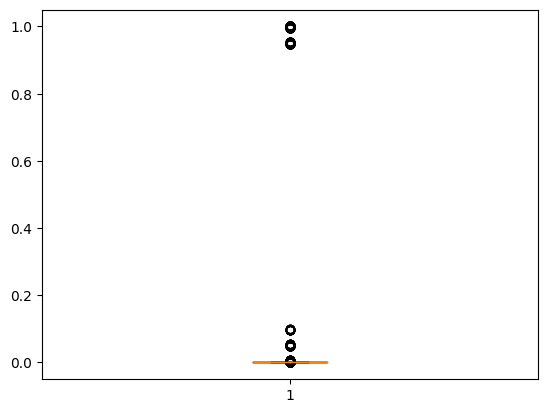

In [82]:
# uccr_ira
import matplotlib.pyplot as plt
uccr_ira_score = ira_scores
print(np.average(uccr_ira_score))
plt.boxplot(uccr_ira_score)

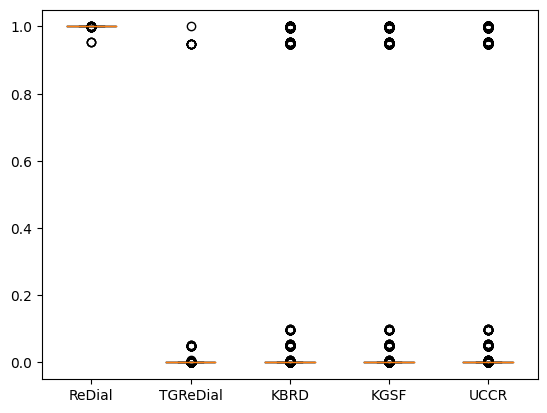

In [83]:
%matplotlib inline
plt.boxplot([redial_ira_score, tgredial_ira_score, kbrd_ira_score, kgsf_ira_score, uccr_ira_score], labels=['ReDial', 'TGReDial', 'KBRD', 'KGSF', 'UCCR'])
plt.savefig('ira_bias_tgredial.pdf')